In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from IPython.display import display

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tools.get_describe_record import get_describe_record

In [24]:
raw_df = pd.read_excel("../data/raw/kadai.xlsx")
raw_df.head(2)

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.2,0.67,0.15,0.08,67.15,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.8,0.68,0.15,0.08,56.11,...,0.1,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04


In [25]:
processe = raw_df.copy()
processe["batch_id"] = processe.groupby("process_end_time").ngroup()
processe.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,batch_id
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.04,6.4,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0


In [26]:
tagged_anormaly = pd.read_csv("../data/processed/processe_tagged_anormaly.csv")
tagged_anormaly.head()

,process_end_time,final_mes_time,OV,X1,X2,X3,X4,X5,X6,X7,...,X77,X78,X79,X80,X81,X82,X83,batch_id,batch_OV_std,is_anomaly
0,2016-08-14 23:07:00,2016-09-24 04:22:00,111.2886,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
1,2016-08-14 23:07:00,2016-09-24 10:12:00,201.5617,22.45,9.40,803.80,0.68,0.15,0.08,56.11,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
2,2016-08-14 23:07:00,2016-09-24 14:11:00,111.9410,22.03,1.14,594.52,0.64,0.14,0.08,51.57,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
3,2016-08-14 23:07:00,2016-09-24 15:30:00,182.3914,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1
4,2016-08-14 23:07:00,2016-09-24 18:31:00,196.2703,22.98,1.37,797.20,0.67,0.15,0.08,67.15,...,0.58,0.0,4.1,0.0,0.01,0.16,0.04,0,53.414865,1


In [27]:
anomaly = tagged_anormaly[tagged_anormaly["is_anomaly"] == 1]
nomaly = tagged_anormaly[tagged_anormaly["is_anomaly"] == 0]

## 異常スパイク部分の予測モデル構築

In [28]:
train_df = anomaly[anomaly["batch_id"] < 75]
test_df = anomaly[anomaly["batch_id"] >= 75]

train_df = train_df.drop(columns=["is_anomaly","batch_OV_std", "batch_id", "process_end_time", "final_mes_time"])
test_df = test_df.drop(columns=["is_anomaly","batch_OV_std", "batch_id", "process_end_time", "final_mes_time"])

display(train_df)
display(test_df)

,OV,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
0,111.28860,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
1,201.56170,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,33.98,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
2,111.94100,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,10.44,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
3,182.39140,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
4,196.27030,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,...,0.10,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316,115.27540,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1317,192.31780,25.85,1.18,490.90,0.82,0.15,0.07,309.24,14.61,13.89,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1318,91.62728,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04
1319,101.93840,21.58,0.88,80.59,0.51,0.11,0.05,29.89,1.15,2.62,...,0.04,0.09,12.0,0.19,0.0,2.9,0.01,0.01,0.17,0.04


,OV,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83
1846,127.71120,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1847,139.05970,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1848,259.36600,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1849,78.71875,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
1850,77.78309,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,...,0.03,0.26,6.50,0.20,0.00,2.70,0.02,0.01,0.25,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,164.41780,24.94,56.62,655.34,0.62,0.14,0.07,25.69,2.19,14.11,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2190,285.22330,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2191,395.77340,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38
2192,115.75990,24.94,56.62,655.34,0.62,0.14,0.07,25.69,2.19,14.11,...,0.10,0.33,22.59,0.08,0.66,0.29,0.60,0.36,0.11,0.38


In [29]:

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
SENSOR_COLS = [f"X{i}" for i in [27, 30, 41, 25, 36]]
LAGS = [1, 2, 3, 5, 10, 20]
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
"""
"X36", "X27","X30", "X41"
X30    0.671984
X41    0.368569
X27    0.353834
X25    0.337130
"""
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
def feature_engineering1(df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS):
    feat_df = df[SENSOR_COLS].copy()

    for c in SENSOR_COLS:
        for l in LAGS:
            feat_df[f"{c}_lag{l}"] = df[c].shift(l)

        feat_df[f"{c}_diff1"] = feat_df[c].diff(1)
        feat_df[f"{c}_diff2"] = feat_df[c].diff(2)
        feat_df[f"{c}_pct1"]  = feat_df[c].pct_change(1).replace([np.inf, -np.inf], np.nan)
    feat_df = feat_df.ffill().bfill().fillna(0)
    return feat_df
#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  


train_feature_df = feature_engineering1(train_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS)
test_feature_df = feature_engineering1(test_df, SENSOR_COLS=SENSOR_COLS, LAGS=LAGS)

In [30]:
"""
X30    0.671984
X41    0.368569
X27    0.353834
X25    0.337130
"""



pipeline = Pipeline([
    ("scaler", StandardScaler()),
    (
        "model",
        RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            min_samples_leaf=3,
            random_state=42
        )
    )
])

train_X = train_df
test_X = test_df

pipeline.fit(train_feature_df, train_df["OV"])

with open("../data/model/spike_predict_lgbm.pkl", "wb") as f:
    pickle.dump(pipeline, f)

## 平常時の予測

In [31]:
feat = [f"X{i}" for i in range(1, 84)] + ["OV"]

train_df = tagged_anormaly.loc[tagged_anormaly["batch_id"] < 75, feat]
test_df  = tagged_anormaly.loc[tagged_anormaly["batch_id"] >= 75, feat]

display(train_df)
display(test_df)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,OV
0,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,111.28860
1,22.45,9.40,803.80,0.68,0.15,0.08,56.11,5.27,33.98,0.96,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,201.56170
2,22.03,1.14,594.52,0.64,0.14,0.08,51.57,6.15,10.44,0.94,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,111.94100
3,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,182.39140
4,22.98,1.37,797.20,0.67,0.15,0.08,67.15,9.86,37.23,0.94,...,0.04,6.4,0.58,0.0,4.1,0.00,0.01,0.16,0.04,196.27030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,82.84555
1762,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,0.92,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,78.26471
1763,24.35,4.92,635.52,0.64,0.14,0.09,78.09,3.22,6.29,0.92,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,101.99680
1764,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,90.90938


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X75,X76,X77,X78,X79,X80,X81,X82,X83,OV
1766,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,144.50520
1767,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,107.27810
1768,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,145.55110
1769,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,110.57250
1770,23.62,9.35,705.91,0.64,0.14,0.08,127.48,4.25,7.30,0.93,...,0.26,6.5,0.20,0.0,2.7,0.02,0.01,0.25,0.04,120.00390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,0.83,...,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03,74.94453
2272,24.94,56.62,655.34,0.62,0.14,0.07,25.69,2.19,14.11,0.89,...,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03,59.39213
2273,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,0.83,...,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03,70.32605
2274,25.22,14.40,397.21,0.59,0.14,0.08,38.31,2.17,53.05,0.83,...,0.21,15.0,0.12,0.0,7.1,0.00,0.02,0.49,0.03,77.89170


In [32]:
pipeline = Pipeline([
    #("scaler", StandardScaler()),
    ("scaler", StandardScaler()),
    ("model", LGBMRegressor(
        objective="regression",
        metric="rmse",
        verbose=-1,
        random_state=42
    ))
])

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  
normal_features = ["X14", "X30", "X33", "X83"]

#Attention:------------------Attention:------------------Attention:------------------Attention:------------------Attention:------------------  


pipeline.fit(train_df[normal_features], train_df["OV"])

with open("../data/model/non_spike_predict.pkl", "wb") as f:
    pickle.dump(pipeline, f)

pred = pipeline.predict(test_df[normal_features])

rmse = np.sqrt(mean_squared_error(test_df["OV"], pred))
print(f"RMSE (nomaly only): {rmse:.3f}")

RMSE (nomaly only): 75.684


# 全体予測

In [33]:
with open("../data/model/spike_detection_IFmodel.pkl", "rb") as f:
    spike_model = pickle.load(f)

with open("../data/model/spike_predict_lgbm.pkl", "rb") as f:
    spike_predict_model = pickle.load(f)

with open("../data/model/non_spike_predict.pkl", "rb") as f:
    non_spike_predict_model = pickle.load(f)

with open("../data/score/IF_train_score.pkl", "rb") as f:
    score_train = pickle.load(f)
thr = np.quantile(score_train, 0.90)

In [34]:
# スパイク発生ロット
SENSOR_COLS = [f"X{i}" for i in [27, 30, 41, 25, 36]]
LAGS = [1, 2, 3, 5, 10, 20]

# 通常ロット
normal_features = ["X14", "X30", "X33", "X83"]

RMSE: 50.369


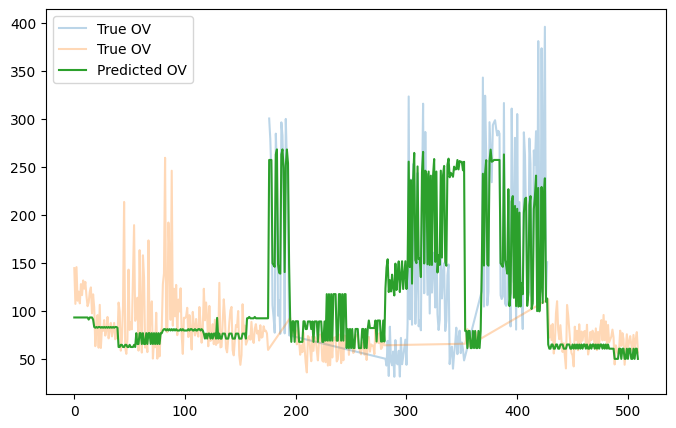

In [35]:
rows = []

for batch in range(75, 100):

    batch_df = processe[processe["batch_id"] == batch]
    batch_OV = batch_df["OV"].values

    # --- スパイク判定 ---
    desc_df = get_describe_record(df=processe, batch=batch)
    if hasattr(desc_df, "ndim") and desc_df.ndim == 1:
        desc_df = desc_df.to_frame().T

    score_test = -spike_model.score_samples(desc_df)
    is_spike = int((score_test >= thr).item())

    # --- 予測 ---
    if is_spike == 1:
        feature_df = feature_engineering1(
            batch_df,
            SENSOR_COLS=SENSOR_COLS,
            LAGS=LAGS
        )
        pred = spike_predict_model.predict(feature_df)
    else:
        feature_df = batch_df[normal_features]
        pred = non_spike_predict_model.predict(feature_df)

    # --- val_df に追加（★ここが重要） ---
    tmp_df = pd.DataFrame({
        "trueOV": batch_OV,
        "predOV": pred,
        "batch_id": batch,
        "is_spike": is_spike
    })
    rows.append(tmp_df)

val_df = pd.concat(rows, ignore_index=True)
rmse = np.sqrt(mean_squared_error(val_df["trueOV"], val_df["predOV"]))
print(f"RMSE: {rmse:.3f}")

plt.figure(figsize=(8, 5))
mask_spike = val_df["is_spike"] == 1
plt.plot(val_df.index[mask_spike], val_df["trueOV"][mask_spike], label="True OV", alpha=0.3)
mask_normal = val_df["is_spike"] == 0
plt.plot(val_df.index[mask_normal], val_df["trueOV"][mask_normal], label="True OV", alpha=0.3)
plt.plot(val_df.index, val_df["predOV"], label="Predicted OV")

plt.legend()
plt.show()
